In [1]:
%env MY_ENV_VAR=value

env: MY_ENV_VAR=value


# Load libraries and prepare the dataset

In [3]:
#Import the required Libraries
import os
import numpy as np
import tensorflow as tf
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Activation, BatchNormalization, Reshape
from tensorflow.keras import backend 
from tensorflow.keras.optimizers import SGD, Adadelta
from tensorflow.keras.layers import LeakyReLU
config=tf.compat.v1.ConfigProto()
sess = tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
import pickle
import matplotlib.pyplot as plt 
import sys


C:\Users\Rishi\anaconda3\envs\altair\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Rishi\anaconda3\envs\altair\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Rishi\anaconda3\envs\altair\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Rishi\anaconda3\envs\altair\lib\site-packages\tensorflow\pyth

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from tensorflow.compat.v1.keras.backend import set_session

In [2]:
import gdal

In [5]:
#Define File directories
Data_folder = "D:\\MEGA BACKUP\\PC\\Nielit\\landslides\\first"
IMAGE_PATH = os.path.join(Data_folder, "image")
LABEL_PATH = os.path.join(Data_folder, 'imagemask')

#Load and prepare the required dataset

In [6]:
#Create list of the VHR images 
image_list={}
for f in sorted(os.listdir(IMAGE_PATH)):
    fdir = os.path.join(IMAGE_PATH, f)
    _, ext = os.path.splitext(f)
    if ext.lower() == ".tif":
        imgtype = f[-9:-4]
        image_data=gdal.Open(fdir)
        bands = [image_data.GetRasterBand(i+1).ReadAsArray() for i in range(image_data.RasterCount)]
        image_list[imgtype] = np.stack(bands, axis=2)

In [7]:
#Create list of Lables
label_list={}
for f in sorted(os.listdir(LABEL_PATH)):
    fdir = os.path.join(LABEL_PATH, f)
    _, ext = os.path.splitext(f)
    if ext.lower() == ".tif":
        imgtype = f[-9:-4]
        label_data=gdal.Open(fdir)
        bands = [label_data.GetRasterBand(i+1).ReadAsArray() for i in range(label_data.RasterCount)]
        label_list[imgtype] = np.stack(bands, axis=2)

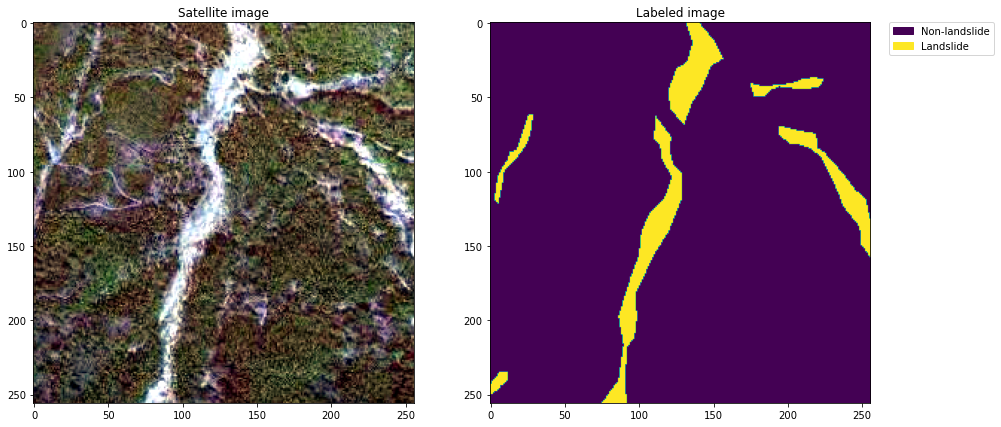

In [8]:
#visualize both images 
sample_image="00004"
sample_label="00004"

def visualize_data(data,data2):
    f, axarr = plt.subplots(1,2)
    data = data[:, :, 0:3]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(np.float)
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    axarr[0].imshow(data)
    axarr[0].set_title("Satellite image")

    a=axarr[1]
    values = np.unique(data2.ravel())
    im = axarr[1].imshow(data2[:,:,0])
    a.set_title("Labeled image")
    colors = [im.cmap(im.norm(value)) for value in values] 
    data2 = ["Non-landslide", "Landslide"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), data2)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

visualize_data(image_list[sample_image],label_list[sample_label])


In [9]:
#convert data into smaller patches and keras usable formats

PATCHSIZE = 128
NBANDS = image_list["00001"].shape[-1]

def gridwise_sample(imgarray, patchsize):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Ytrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.uint8)
# sample each training tile systematically in a gridwise manner
train_areas = ["00000", "00001", "00002","00003","00004","00005", "06","07", "08", "09"]
for area in train_areas:
    X_toadd = gridwise_sample(image_list[area], PATCHSIZE)
    Y_toadd = gridwise_sample(label_list[area], PATCHSIZE)
    Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)
# encode all non-landslide classes as one class
Ytrain[Ytrain!=2] = 1
print("There are %i number of training patches" % (Xtrain.shape[0]))

There are 40 number of training patches


In [10]:
#Check the percentage of landslide pixels with respect to non-landslides
ls_px=len(Ytrain[Ytrain==2])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==2]))
nonls_px=len(Ytrain[Ytrain==1])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==2]))
print("Pixel percentage of landslides = " + str(ls_px* 100)) #We can observe that the percentage of landslide pixels are really less (<10%)
print("Pixel percentage of non-landslides = " + str(nonls_px* 100)) 

Pixel percentage of landslides = 3.2992553710937496
Pixel percentage of non-landslides = 96.70074462890625


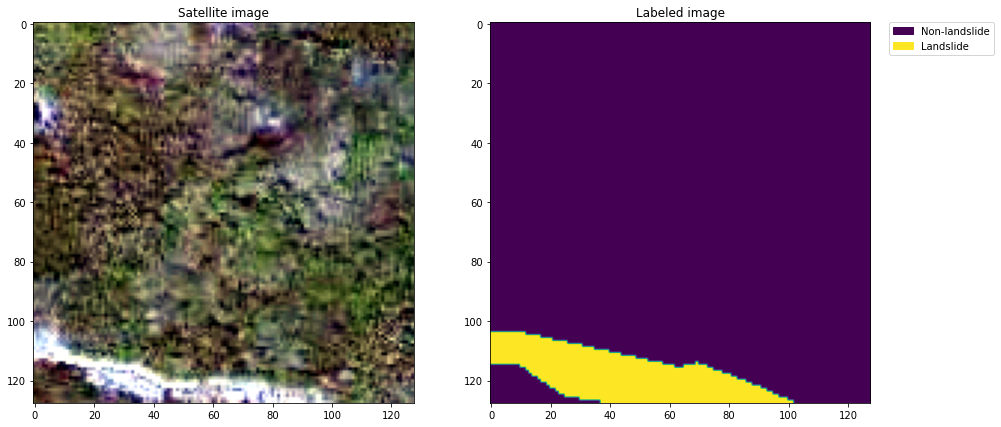

In [11]:
#Visualize the Patches of Image
PATCH_NO = 30
visualize_data(Xtrain[PATCH_NO],Ytrain[PATCH_NO])

**`Convert the label data to categorical as one-hot encoding`**

In [12]:
def to_categorical_4d(y, nc):
    Y = np.zeros((y.shape[0],
                  y.shape[1],
                  y.shape[2],
                  nc),
                  dtype=np.int32)
    for h in range(y.shape[0]):
        for i in range(y.shape[1]):
            for j in range(y.shape[2]):
                if y[h, i, j, 0] != 0:
                    Y[h, i, j, y[h, i, j, 0]-1] = 1
                else:
                    continue
    return Y
# transform target arrays to one-hot encodings
Ytrain = to_categorical_4d(Ytrain, 2)

# Model generation (FCN) and training phase

In [13]:
#Model builder

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.compat.v1.Session(config=config))

NUMBER_BANDS = 3
NUMBER_CLASSES = 2
NUMBER_EPOCHS = 500  
nclasses=2
def build_FCN(optimizer, nrows, ncols, nbands,nclasses):
    model = tf.keras.models.Sequential()
    model.add(ZeroPadding2D((2, 2), input_shape=(nrows, ncols, nbands)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((2, 2)))
    model.add(MaxPooling2D(
              pool_size=(5, 5),
              strides=(1, 1)
    ))
    model.add(ZeroPadding2D((4, 4)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(2, 2)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((4, 4)))
    model.add(MaxPooling2D(
            pool_size=(9, 9),
            strides=(1, 1)
    ))
    model.add(ZeroPadding2D((6, 6)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(3, 3)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((6, 6)))
    model.add(MaxPooling2D(
            pool_size=(13, 13),
            strides=(1, 1)
    ))
    model.add(Convolution2D(
              filters=nclasses,
              kernel_size=(1, 1)
    ))
    model.add(tf.keras.layers.Activation(
              activation="softmax"
    ))
    model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)
    return model

def recall_m(y_true, y_pred):
    true_positives = tf.compat.v1.keras.backend.sum(tf.compat.v1.keras.backend.round(tf.compat.v1.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.compat.v1.keras.backend.sum(tf.compat.v1.keras.backend.round(tf.compat.v1.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.compat.v1.keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = tf.compat.v1.keras.backend.sum(tf.compat.v1.keras.backend.round(tf.compat.v1.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.compat.v1.keras.backend.sum(tf.compat.v1.keras.backend.round(tf.compat.v1.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.compat.v1.keras.backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+tf.compat.v1.keras.backend.epsilon()))

opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
fcn = build_FCN(opt, PATCHSIZE, PATCHSIZE, NUMBER_BANDS,NUMBER_CLASSES)

fcn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m]) # Use of'adam' optimiser

In [14]:
fcn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 132, 132, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 132, 132, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 136, 136, 32)      0

***Train the model***

In [15]:
def train(model, data, labels):
    hist = model.fit(x=data,
                     y=labels,
                     epochs=NUMBER_EPOCHS,
                     verbose=2
                    )
    return hist

history = train(fcn, Xtrain, Ytrain)

Epoch 1/500
2/2 - 7s - loss: 1.0070 - acc: 0.4171 - f1_m: 0.5567 - precision_m: 0.5567 - recall_m: 0.5567
Epoch 2/500
2/2 - 6s - loss: 0.4553 - acc: 0.8657 - f1_m: 0.8787 - precision_m: 0.8787 - recall_m: 0.8787
Epoch 3/500
2/2 - 6s - loss: 0.3535 - acc: 0.9377 - f1_m: 0.9455 - precision_m: 0.9455 - recall_m: 0.9455
Epoch 4/500
2/2 - 6s - loss: 0.2956 - acc: 0.9532 - f1_m: 0.9507 - precision_m: 0.9507 - recall_m: 0.9507
Epoch 5/500
2/2 - 6s - loss: 0.2457 - acc: 0.9628 - f1_m: 0.9674 - precision_m: 0.9674 - recall_m: 0.9674
Epoch 6/500
2/2 - 6s - loss: 0.2147 - acc: 0.9700 - f1_m: 0.9668 - precision_m: 0.9668 - recall_m: 0.9668
Epoch 7/500
2/2 - 6s - loss: 0.1986 - acc: 0.9668 - f1_m: 0.9699 - precision_m: 0.9699 - recall_m: 0.9699
Epoch 8/500
2/2 - 6s - loss: 0.1799 - acc: 0.9721 - f1_m: 0.9681 - precision_m: 0.9681 - recall_m: 0.9681
Epoch 9/500
2/2 - 6s - loss: 0.1622 - acc: 0.9740 - f1_m: 0.9767 - precision_m: 0.9767 - recall_m: 0.9767
Epoch 10/500
2/2 - 6s - loss: 0.1496 - acc: 0.

Epoch 78/500
2/2 - 6s - loss: 0.0528 - acc: 0.9847 - f1_m: 0.9846 - precision_m: 0.9846 - recall_m: 0.9846
Epoch 79/500
2/2 - 6s - loss: 0.0468 - acc: 0.9849 - f1_m: 0.9838 - precision_m: 0.9838 - recall_m: 0.9838
Epoch 80/500
2/2 - 6s - loss: 0.0569 - acc: 0.9777 - f1_m: 0.9745 - precision_m: 0.9745 - recall_m: 0.9745
Epoch 81/500
2/2 - 6s - loss: 0.0605 - acc: 0.9815 - f1_m: 0.9824 - precision_m: 0.9824 - recall_m: 0.9824
Epoch 82/500
2/2 - 6s - loss: 0.0537 - acc: 0.9835 - f1_m: 0.9853 - precision_m: 0.9853 - recall_m: 0.9853
Epoch 83/500
2/2 - 6s - loss: 0.0685 - acc: 0.9748 - f1_m: 0.9788 - precision_m: 0.9788 - recall_m: 0.9788
Epoch 84/500
2/2 - 6s - loss: 0.0494 - acc: 0.9830 - f1_m: 0.9841 - precision_m: 0.9841 - recall_m: 0.9841
Epoch 85/500
2/2 - 6s - loss: 0.0573 - acc: 0.9828 - f1_m: 0.9832 - precision_m: 0.9832 - recall_m: 0.9832
Epoch 86/500
2/2 - 6s - loss: 0.0492 - acc: 0.9834 - f1_m: 0.9856 - precision_m: 0.9856 - recall_m: 0.9856
Epoch 87/500
2/2 - 6s - loss: 0.0582 

2/2 - 6s - loss: 0.0368 - acc: 0.9883 - f1_m: 0.9905 - precision_m: 0.9905 - recall_m: 0.9905
Epoch 155/500
2/2 - 6s - loss: 0.0396 - acc: 0.9832 - f1_m: 0.9789 - precision_m: 0.9789 - recall_m: 0.9789
Epoch 156/500
2/2 - 6s - loss: 0.0323 - acc: 0.9890 - f1_m: 0.9866 - precision_m: 0.9866 - recall_m: 0.9866
Epoch 157/500
2/2 - 6s - loss: 0.0406 - acc: 0.9870 - f1_m: 0.9878 - precision_m: 0.9878 - recall_m: 0.9878
Epoch 158/500
2/2 - 6s - loss: 0.0328 - acc: 0.9881 - f1_m: 0.9889 - precision_m: 0.9889 - recall_m: 0.9889
Epoch 159/500
2/2 - 6s - loss: 0.0410 - acc: 0.9824 - f1_m: 0.9850 - precision_m: 0.9850 - recall_m: 0.9850
Epoch 160/500
2/2 - 6s - loss: 0.0335 - acc: 0.9890 - f1_m: 0.9883 - precision_m: 0.9883 - recall_m: 0.9883
Epoch 161/500
2/2 - 6s - loss: 0.0340 - acc: 0.9890 - f1_m: 0.9887 - precision_m: 0.9887 - recall_m: 0.9887
Epoch 162/500
2/2 - 6s - loss: 0.0338 - acc: 0.9869 - f1_m: 0.9889 - precision_m: 0.9889 - recall_m: 0.9889
Epoch 163/500
2/2 - 6s - loss: 0.0326 - ac

Epoch 230/500
2/2 - 6s - loss: 0.0241 - acc: 0.9913 - f1_m: 0.9916 - precision_m: 0.9916 - recall_m: 0.9916
Epoch 231/500
2/2 - 6s - loss: 0.0242 - acc: 0.9914 - f1_m: 0.9889 - precision_m: 0.9889 - recall_m: 0.9889
Epoch 232/500
2/2 - 6s - loss: 0.0269 - acc: 0.9910 - f1_m: 0.9915 - precision_m: 0.9915 - recall_m: 0.9915
Epoch 233/500
2/2 - 6s - loss: 0.0230 - acc: 0.9923 - f1_m: 0.9931 - precision_m: 0.9931 - recall_m: 0.9931
Epoch 234/500
2/2 - 6s - loss: 0.0267 - acc: 0.9889 - f1_m: 0.9879 - precision_m: 0.9879 - recall_m: 0.9879
Epoch 235/500
2/2 - 6s - loss: 0.0268 - acc: 0.9912 - f1_m: 0.9898 - precision_m: 0.9898 - recall_m: 0.9898
Epoch 236/500
2/2 - 6s - loss: 0.0249 - acc: 0.9915 - f1_m: 0.9920 - precision_m: 0.9920 - recall_m: 0.9920
Epoch 237/500
2/2 - 6s - loss: 0.0272 - acc: 0.9893 - f1_m: 0.9895 - precision_m: 0.9895 - recall_m: 0.9895
Epoch 238/500
2/2 - 6s - loss: 0.0249 - acc: 0.9914 - f1_m: 0.9907 - precision_m: 0.9907 - recall_m: 0.9907
Epoch 239/500
2/2 - 6s - los

Epoch 306/500
2/2 - 6s - loss: 0.0213 - acc: 0.9926 - f1_m: 0.9928 - precision_m: 0.9928 - recall_m: 0.9928
Epoch 307/500
2/2 - 6s - loss: 0.0232 - acc: 0.9908 - f1_m: 0.9928 - precision_m: 0.9928 - recall_m: 0.9928
Epoch 308/500
2/2 - 6s - loss: 0.0211 - acc: 0.9921 - f1_m: 0.9919 - precision_m: 0.9919 - recall_m: 0.9919
Epoch 309/500
2/2 - 6s - loss: 0.0205 - acc: 0.9927 - f1_m: 0.9935 - precision_m: 0.9935 - recall_m: 0.9935
Epoch 310/500
2/2 - 6s - loss: 0.0202 - acc: 0.9929 - f1_m: 0.9939 - precision_m: 0.9939 - recall_m: 0.9939
Epoch 311/500
2/2 - 6s - loss: 0.0203 - acc: 0.9925 - f1_m: 0.9929 - precision_m: 0.9929 - recall_m: 0.9929
Epoch 312/500
2/2 - 6s - loss: 0.0197 - acc: 0.9930 - f1_m: 0.9930 - precision_m: 0.9930 - recall_m: 0.9930
Epoch 313/500
2/2 - 6s - loss: 0.0192 - acc: 0.9933 - f1_m: 0.9941 - precision_m: 0.9941 - recall_m: 0.9941
Epoch 314/500
2/2 - 6s - loss: 0.0195 - acc: 0.9933 - f1_m: 0.9921 - precision_m: 0.9921 - recall_m: 0.9921
Epoch 315/500
2/2 - 6s - los

Epoch 382/500
2/2 - 6s - loss: 0.0188 - acc: 0.9932 - f1_m: 0.9921 - precision_m: 0.9921 - recall_m: 0.9921
Epoch 383/500
2/2 - 6s - loss: 0.0183 - acc: 0.9934 - f1_m: 0.9923 - precision_m: 0.9923 - recall_m: 0.9923
Epoch 384/500
2/2 - 6s - loss: 0.0172 - acc: 0.9939 - f1_m: 0.9929 - precision_m: 0.9929 - recall_m: 0.9929
Epoch 385/500
2/2 - 6s - loss: 0.0195 - acc: 0.9930 - f1_m: 0.9929 - precision_m: 0.9929 - recall_m: 0.9929
Epoch 386/500
2/2 - 6s - loss: 0.0176 - acc: 0.9935 - f1_m: 0.9921 - precision_m: 0.9921 - recall_m: 0.9921
Epoch 387/500
2/2 - 6s - loss: 0.0163 - acc: 0.9944 - f1_m: 0.9941 - precision_m: 0.9941 - recall_m: 0.9941
Epoch 388/500
2/2 - 6s - loss: 0.0193 - acc: 0.9930 - f1_m: 0.9933 - precision_m: 0.9933 - recall_m: 0.9933
Epoch 389/500
2/2 - 6s - loss: 0.0171 - acc: 0.9937 - f1_m: 0.9920 - precision_m: 0.9920 - recall_m: 0.9920
Epoch 390/500
2/2 - 6s - loss: 0.0164 - acc: 0.9943 - f1_m: 0.9949 - precision_m: 0.9949 - recall_m: 0.9949
Epoch 391/500
2/2 - 6s - los

Epoch 458/500
2/2 - 7s - loss: 0.0149 - acc: 0.9950 - f1_m: 0.9954 - precision_m: 0.9954 - recall_m: 0.9954
Epoch 459/500
2/2 - 6s - loss: 0.0142 - acc: 0.9952 - f1_m: 0.9953 - precision_m: 0.9953 - recall_m: 0.9953
Epoch 460/500
2/2 - 6s - loss: 0.0160 - acc: 0.9936 - f1_m: 0.9932 - precision_m: 0.9932 - recall_m: 0.9932
Epoch 461/500
2/2 - 7s - loss: 0.0152 - acc: 0.9948 - f1_m: 0.9948 - precision_m: 0.9948 - recall_m: 0.9948
Epoch 462/500
2/2 - 6s - loss: 0.0146 - acc: 0.9950 - f1_m: 0.9950 - precision_m: 0.9950 - recall_m: 0.9950
Epoch 463/500
2/2 - 6s - loss: 0.0156 - acc: 0.9938 - f1_m: 0.9941 - precision_m: 0.9941 - recall_m: 0.9941
Epoch 464/500
2/2 - 6s - loss: 0.0144 - acc: 0.9951 - f1_m: 0.9955 - precision_m: 0.9955 - recall_m: 0.9955
Epoch 465/500
2/2 - 6s - loss: 0.0140 - acc: 0.9953 - f1_m: 0.9964 - precision_m: 0.9964 - recall_m: 0.9964
Epoch 466/500
2/2 - 6s - loss: 0.0156 - acc: 0.9938 - f1_m: 0.9952 - precision_m: 0.9952 - recall_m: 0.9952
Epoch 467/500
2/2 - 6s - los

# Visualisation of the output curve and saving as weights

Visualize Learning Curve

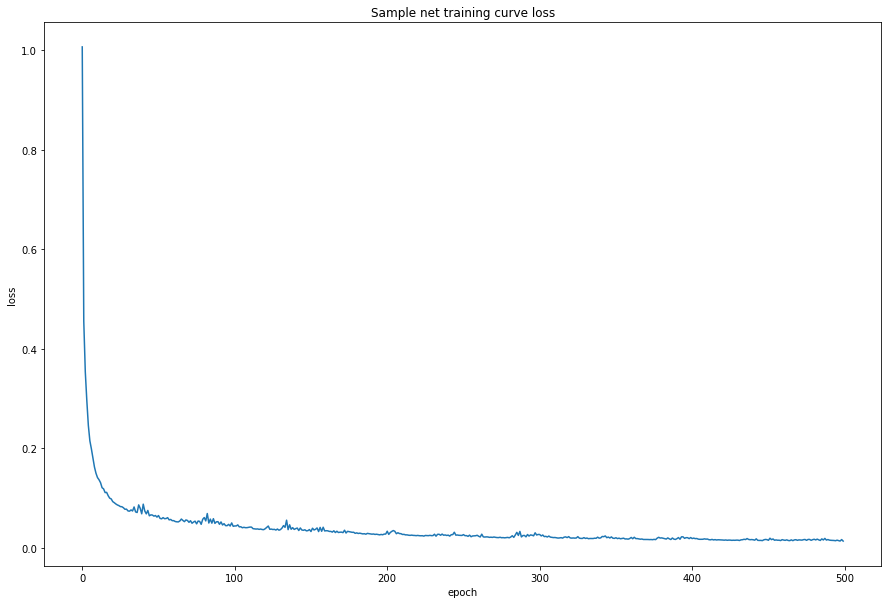

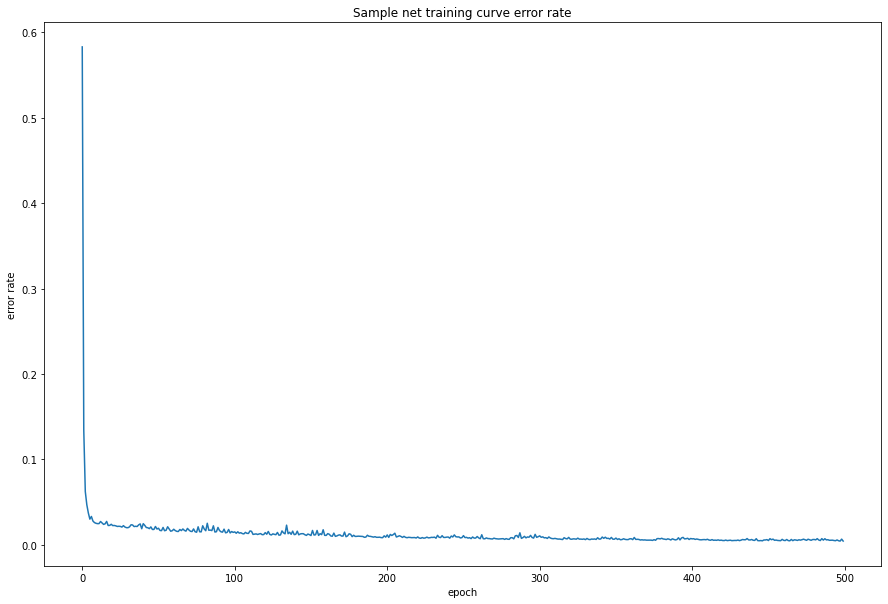

In [16]:
# plot learning curve
plt.plot(history.history["loss"])
plt.title("Sample net training curve loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
plt.plot(1-np.array(history.history["acc"]))
plt.title("Sample net training curve error rate")
plt.ylabel("error rate")
plt.xlabel("epoch")
plt.show()

Save output

In [ ]:
# save the trained network
import imp, h5py
imp.reload(h5py)
model_fname = "D:\\MEGA BACKUP\\PC\\Nielit\\landslides\\FCN_train_weights.hdf5"
fcn.save(model_fname)

# Testing phase 

In [25]:
Xtest = image_list["11"] #Test against tile 11 and 12
Ytest = label_list["11"]
cut = 128
overlap = 96

In [26]:
def evaluate_predictions(Xtest,cut, overlap, Ytest):
    """
    Function to predict full tiles strip-wise (as loading whole tiles might not fit in the memory).
    """
    Ytest = Ytest.copy()
    Ytest[Ytest!=2] = 0
    Ytest[Ytest==2] = 1
    ncols, nrows, nbands = Xtest.shape
    Xtest = np.expand_dims(Xtest, axis=0)
    total_map = np.zeros((nrows, ncols), dtype=np.uint8)
    first = True
    last = False
    if nrows%cut==0:
        numstrips = int(nrows/cut)
    else:
        numstrips = int(nrows/cut) + 1
    for i in range(numstrips):
        print("Strip number: %d" % i)
        if first:
            striptop = 0
            stripbottom = overlap
            height = cut
            X_sub = Xtest[:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
            first = False
        elif (not first) and (cut*(i+1)+1+overlap < nrows):
            striptop = overlap
            stripbottom = overlap
            height = cut
            X_sub = Xtest[:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
        else:
            print("Last hit!")
            striptop = overlap
            stripbottom = 0
            height = nrows - cut*i
            if (striptop+height)%(4)!=0:
                height = height*4
            X_sub = Xtest[:, -(striptop+height):, :, :]
            last = True        
        sub_nrows = X_sub.shape[1]
        sub_ncols = X_sub.shape[2]
        model = fcn
        
        sub_ns, sub_nb, _, __ = X_sub.shape
        cmap = model.predict_on_batch([X_sub])
        cmap = np.argmax(cmap[0], axis=2)
        if not last:
            total_map[cut*i:cut*i+height, :] = cmap[striptop:striptop+height, 0:total_map.shape[1]]
        else:
            total_map[-(height):, :] = cmap[-(height):, 0:total_map.shape[1]]
    return total_map
predictions_FCN = evaluate_predictions(Xtest, cut, overlap, Ytest)

Strip number: 0
Strip number: 1
Last hit!


In [27]:
import string
from matplotlib import colors
from sklearn.metrics import f1_score, precision_score, recall_score

# set color codes of the classes
_others = [221, 61, 14]
_slums = [200, 199, 219]
ccolors = (_slums, _others)
NROWS, NCOLS, NBANDS = Xtest.shape


def print_map(predictions, idxarray, filename=None, title=None, ccolors=None):
    """Print the classified map.

    Keyword arguments:
    predictions -- the array output labels from the classification
    results
    idxarray -- the array of indices of the classified samples
    to be plotted.
    filename -- the name (with the directory) of the file where to
    write the map.
    ccolors -- an array of tuples containing rgb values for the classes
    Both arrays should match and be arranged accordingly. And the
    index of the color should match the value of the of prediction.
    """
    if predictions.size != idxarray.shape[0]:
        raise ValueError("There should be the same number of " +
                         "predictions and indices.")
    nrows, ncols = np.max(idxarray[:, 0])+1, np.max(idxarray[:, 1])+1
    classifiedmap = np.zeros((nrows, ncols, 3), dtype="uint8")
    idx = 0
    for prediction in predictions:
        classifiedmap[idxarray[idx, 0],
                      idxarray[idx, 1]] = np.asarray(ccolors[prediction])
        idx += 1
    if filename is None:
        fig = plt.figure()
        plt.imshow(classifiedmap)
        if title:
            plt.suptitle(title)
        plt.show()
    else:
        output_raster = gdal.GetDriverByName('GTiff').Create(filename,
                                                             NCOLS,
                                                             NROWS,
                                                             NUMBER_CLASSES,
                                                             gdal.GDT_Byte)
        for i in range(NUMBER_CLASSES):
            output_raster.GetRasterBand(i+1).WriteArray(classifiedmap.astype(np.uint8)[:, :, i])


def get_confusion_matrix(predictions, labels):
    """Compute the confusion matrix.

    Keyword arguments:
    prediction -- the array output labels from the classification
    results
    labels -- the  array of "true" labels from the test set
    Both arrays should match, be arranged accordingly, and
    have non-negative values.
    """
    classes = np.unique(labels)
    nbclasses = classes.size
    if labels.size != predictions.size:
        raise ValueError("There should be the same number of " +
                         "predictions and labels.")
    merged = np.concatenate((predictions.reshape(predictions.size, 1),
                             labels.reshape(labels.size, 1)), axis=1)
    CM = np.zeros((classes[-1] + 1, classes[-1] + 1))
    for c1 in classes:
        for c2 in classes:
            CM[c1, c2] = np.sum(np.logical_and(merged[:, 1] == c1,
                                               merged[:, 0] == c2))
    return CM


def cartesian(arrays, out=None):
    """Utility function to create cartesian image coordinates."""
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype
    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)
    m = int(n / arrays[0].size)
    out[:, 0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out


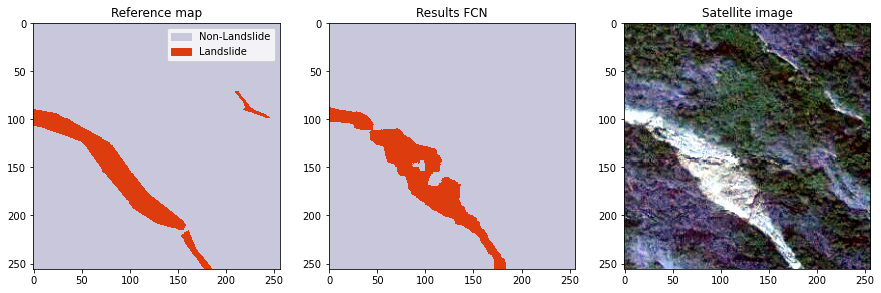

In [28]:
#plot Refrence Map
f, axarr = plt.subplots(1,3)
predictions = predictions_FCN
norm_ccolors = np.array(ccolors)/255.0


fig = axarr[0]
cmap = colors.ListedColormap(norm_ccolors)
bounds=[0,1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)
labels = Ytest[:, :, 0].copy()
labels[labels!=2] = 0
labels[labels==2] = 1
fig.imshow(labels, cmap=cmap, norm=norm, interpolation="nearest", origin="upper")
fig.set_title("Reference map")

ax= axarr[1]
ax.imshow(predictions, cmap=cmap, norm=norm, interpolation="nearest", origin="upper")
ax.set_title("Results FCN")

rectangles = [matplotlib.patches.Rectangle((0, 0), 1, 1, color=norm_ccolors[r]) for r in range(norm_ccolors.shape[0])]
classes = ["Non-Landslide", "Landslide"]
#Create legend from custom artist/label lists
fig.legend(rectangles, classes)
labels = labels.astype("uint8")

data=Xtest
data = data[:, :, 0:3]
_ = data[:, :, 0].copy()
data[:, :, 0] = data[:, :, 2]
data[:, :, 2] = _
data = data.astype(np.float)
for i in range(data.shape[2]):
    p2, p98 = np.percentile(data[:, :, i], (2, 98))
    data[:, :, i] = exposure.rescale_intensity(data[:, :, i],in_range=(p2, p98))

plt_sat=axarr[2]
a=plt_sat.set_title("Satellite image")
_=plt_sat.imshow(data)



In [30]:
CM = get_confusion_matrix(predictions, labels)
print(CM)
OA = np.sum(np.diag(CM))/predictions.size
PA_ls = ((predictions[labels==0]==labels[labels==0]).sum())/(labels[labels==0].size)
PA_nonls = ((predictions[labels==1]==labels[labels==1]).sum())/(labels[labels==1].size)
print("Accuracy metrics of FCN results")
print("Overall Accuracy: %f" % OA)
print("F1 Score: %f" %(f1_score(labels, predictions, average="macro", labels=np.unique(predictions))))
print("PA of Landslide: %f" % PA_ls)
print("PA of Non-Landslide: %f" % PA_nonls)


[[59569.  1669.]
 [  720.  3578.]]
Accuracy metrics of FCN results
Overall Accuracy: 0.963547
F1 Score: 0.823529
PA of Landslide: 0.972746
PA of Non-Landslide: 0.832480
